# Applying XGBoost to the Prima Indian Diabetes dataset

In [83]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from matplotlib import pyplot as plt
%matplotlib inline

In [84]:
df = pd.read_csv('diabetes.csv')

In [85]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Check data types - XGBoost only takes int, float & boolean

In [86]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [87]:
X = df.drop('Outcome', axis=1).copy()
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [88]:
y = df['Outcome'].copy()
y.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

Find how evenly distributed the data is by adding all the positive cases represented by '1' by the total number of cases.<br>
Only 35% of positive cases. <br> 
Stratify the data during train-test split.

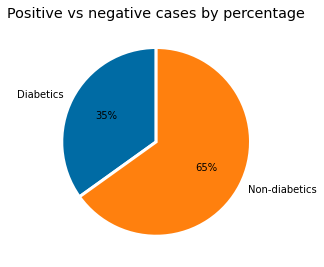

In [89]:
chart_data = [sum(y)/len(y), 1-(sum(y)/len(y))]
plt.style.use('tableau-colorblind10')
plt.title("Positive vs negative cases by percentage")
plt.tight_layout()
plt.pie(chart_data, labels=["Diabetics", "Non-diabetics"], wedgeprops={'edgecolor':"white", "linewidth":3}, startangle=90, autopct='%1.0f%%')
plt.show()

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [93]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=None)
clf_xgb.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.65068
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.64460
[2]	validation_0-aucpr:0.62617
[3]	validation_0-aucpr:0.59556
[4]	validation_0-aucpr:0.64174
[5]	validation_0-aucpr:0.64224
[6]	validation_0-aucpr:0.68016
[7]	validation_0-aucpr:0.68649
[8]	validation_0-aucpr:0.68748
[9]	validation_0-aucpr:0.66949
[10]	validation_0-aucpr:0.66939
[11]	validation_0-aucpr:0.67419
[12]	validation_0-aucpr:0.68190
[13]	validation_0-aucpr:0.67495
[14]	validation_0-aucpr:0.67721
[15]	validation_0-aucpr:0.67072
[16]	validation_0-aucpr:0.66487
[17]	validation_0-aucpr:0.66329
[18]	validation_0-aucpr:0.65401
Stopping. Best iteration:
[8]	validation_0-aucpr:0.68748



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

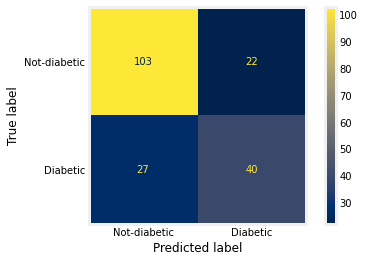

In [118]:
plot_confusion_matrix(clf_xgb, X_test, y_test, display_labels=["Not-diabetic", "Diabetic"], cmap='cividis')
plt.grid(False)

Of the 125 (103 + 22) people who are not diabetic, the algorithm correctly classified 103 **(82.4%)** as non-diabetic (True Negative)<br>
Of the 67 (27 + 40) people who are diabetic, the algorithm correctly classified 40 **(60%)** as diabetic (True Positive)<br>
Conclusion: a little better than a coin-toss to predict diabetes. 

## Optimise Hyper-parameters to get better results